# 1. EDA
数据分析

## Run name

In [1]:
import time
solution_name = 'Titanic'
project_name = 'EDA'
step_name = '1'
time_str = time.strftime("%Y%m%d_%H%M%S", time.localtime())
run_name = '%s_%s_%s_%s' % (solution_name, step_name, project_name, time_str)
print('run_name: ' + run_name)

run_name: Titanic_1_EDA_20190406_230140


## Params

## PKGs

In [2]:
import os
import gc
import random
import zipfile
import h5py
import pickle
import math
from PIL import Image
import shutil
from tqdm import tqdm
import multiprocessing

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
# plt.rc("font",family="SimHei",size="15")  #解决中文乱码问题
from IPython.display import display

C:\Users\study\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
from sklearn.preprocessing import MinMaxScaler

## Folders

In [4]:
CWD = os.getcwd()
input_folder = os.path.join(CWD, 'input')
output_folder = os.path.join(CWD, 'output')
# output_temp_folder = os.path.join(CWD, 'output', date_str)
model_folder = os.path.join(CWD, 'model')
# model_temp_folder = os.path.join(CWD, 'model', date_str)
feature_folder = os.path.join(CWD, 'feature')
log_folder = os.path.join(CWD, 'log')
print('input_folder: \t\t\t%s' % input_folder)
print('output_folder: \t\t\t%s' % output_folder)
# print('output_temp_folder: \t\t%s' % output_temp_folder)
print('model_folder: \t\t\t%s' % model_folder)
# print('model_temp_folder: \t\t%s' % model_temp_folder)
print('feature_folder: \t\t%s' % feature_folder)
print('log_folder: \t\t\t%s' % log_folder)

# if not os.path.exists(output_temp_folder):
#     os.mkdir(output_temp_folder)
#     print('Create folder: %s' % output_temp_folder)
# if not os.path.exists(model_temp_folder):
#     os.mkdir(model_temp_folder)
#     print('Create folder: %s' % model_temp_folder)

train_csv = os.path.join(input_folder, 'train.csv')
test_csv = os.path.join(input_folder, 'test.csv')
sample_submission_csv = os.path.join(input_folder, 'gender_submission.csv')

print(train_csv)
print(test_csv)
print(sample_submission_csv)

input_folder: 			D:\Kaggle\titanic\input
output_folder: 			D:\Kaggle\titanic\output
model_folder: 			D:\Kaggle\titanic\model
feature_folder: 		D:\Kaggle\titanic\feature
log_folder: 			D:\Kaggle\titanic\log
D:\Kaggle\titanic\input\train.csv
D:\Kaggle\titanic\input\test.csv
D:\Kaggle\titanic\input\gender_submission.csv


## Load data

In [5]:
train_df = pd.read_csv(train_csv)
test_df = pd.read_csv(test_csv)
sample_submission_df = pd.read_csv(sample_submission_csv)

display(train_df.shape, train_df.head(2))
display(test_df.shape, test_df.head(2))
display(sample_submission_df.shape, sample_submission_df.head(2))

(891, 12)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C


(418, 11)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S


(418, 2)

,PassengerId,Survived
0,892,0
1,893,1


## Seperate id, y and x

In [6]:
x_train_columns = list(set(train_df.columns) - set(['PassengerId', 'Survived']))
x_test_columns = list(set(test_df.columns) - set(['PassengerId']))
x_train_columns.sort()
x_test_columns.sort()
x_columns = x_train_columns
print(len(x_columns), x_columns)
assert set(x_train_columns) == set(x_test_columns), 'columns of train should be equal to test'

id_train_ser = train_df['PassengerId']
y_train_ser = train_df['Survived']
x_train_df = train_df[x_columns]
display(id_train_ser.shape, id_train_ser.head(2))
display(y_train_ser.shape, y_train_ser.head(2))
display(x_train_df.shape, x_train_df.head(2))

id_test_ser = test_df['PassengerId']
x_test_df = test_df[x_columns]
display(id_test_ser.shape, id_test_ser.head(2))
display(x_test_df.shape, x_test_df.head(2))

10 ['Age', 'Cabin', 'Embarked', 'Fare', 'Name', 'Parch', 'Pclass', 'Sex', 'SibSp', 'Ticket']


(891,)

0    1
1    2
Name: PassengerId, dtype: int64

(891,)

0    0
1    1
Name: Survived, dtype: int64

(891, 10)

,Age,Cabin,Embarked,Fare,Name,Parch,Pclass,Sex,SibSp,Ticket
0,22.0,NaN,S,7.2500,"Braund, Mr. Owen Harris",0,3,male,1,A/5 21171
1,38.0,C85,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,1,female,1,PC 17599


(418,)

0    892
1    893
Name: PassengerId, dtype: int64

(418, 10)

,Age,Cabin,Embarked,Fare,Name,Parch,Pclass,Sex,SibSp,Ticket
0,34.5,NaN,Q,7.8292,"Kelly, Mr. James",0,3,male,0,330911
1,47.0,NaN,S,7.0000,"Wilkes, Mrs. James (Ellen Needs)",0,3,female,1,363272


## Explore features

In [7]:
# Package data
x_data_dfs = [x_train_df, x_test_df]

## is_null
- Every column have a new subattribute is_null_xxx.
- Data will not loss any infomation with is_null_xxx columns.

In [8]:
for column_name in x_columns:
    for x_df in x_data_dfs:
        x_df['id_null_%s' % column_name] = x_df[column_name].isnull()

C:\Users\study\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [9]:
is_null_stat_df = pd.DataFrame(columns=['train', 'test'])
for col_name in x_columns:
    temp_counts = []
    for x_df in x_data_dfs:
        temp_counts.append(x_df['id_null_%s' % col_name].sum())
    is_null_stat_df.loc[col_name] = temp_counts
is_null_stat_df['train_ratio'] = is_null_stat_df['train'] / x_train_df.shape[0]
is_null_stat_df['test_ratio'] = is_null_stat_df['test'] / x_test_df.shape[0]
display(is_null_stat_df.shape, is_null_stat_df)
# As show in dataframe below:
# - is_null of train and test are approximate ratio at 'Age' and 'Cabin', is a similar distribution
# - 'Name', 'Parch' columns and so on, do not have null, so we can drop this is_null_xxx columns at x_data.

(10, 4)

,train,test,train_ratio,test_ratio
Age,177,86,0.198653,0.205742
Cabin,687,327,0.771044,0.782297
Embarked,2,0,0.00224467,0
Fare,0,1,0,0.00239234
Name,0,0,0,0
Parch,0,0,0,0
Pclass,0,0,0,0
Sex,0,0,0,0
SibSp,0,0,0,0
Ticket,0,0,0,0


## Categorial columns
- histogram

In [10]:
# ticket_num_ser = x_df['Ticket'].apply(lambda x: x.split(' ')[-1])
# print(set(ticket_num_ser))

In [11]:
cat_orig_column_arr = ['Sex', 'Ticket', 'Cabin', 'Embarked']
for x_df in x_data_dfs:
#     x_df['cat_Ticket_number'] = x_df['Ticket'].apply(lambda x: re.find())
#     print(set(x_df['Ticket']))
    pass

## Numerical columns
- num_cat_column_arr, just need draw sns.distplot which show count of each categorical value
- num_pure_column_arr
    - discription of features
    - fill nan(standardize can not process nan value)
    - log convert if the distribution of feature is skew
    - standardize if the range of feature is wide
    - sns.distplot
    
- http://seaborn.pydata.org/generated/seaborn.heatmap.html ???
- http://seaborn.pydata.org/tutorial/distributions.html ???
```
g = sns.PairGrid(iris)
g.map_diag(sns.kdeplot)
g.map_offdiag(sns.kdeplot, n_levels=6);
```
- https://blog.csdn.net/lujiandong1/article/details/52654703 ??? fillna???
- https://pypi.org/project/fancyimpute/ ???
- https://github.com/iskandr/knnimpute ???
- https://pypi.org/project/impyute/ ???
- https://www.jianshu.com/p/90220f34f9d5 ???
- [Bayesian multiple imputation for missing multivariate longitudinal data from a Parkinson’s disease clinical trial](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3883900/)
- http://www.bias-project.org.uk/Missing2012/Lectures.pdf
- http://www.stat.columbia.edu/~gelman/arm/missing.pdf
- EM Imputation and Missing Data ???

**Notice: log convertion should be before standardization, otherwise data can't convert to logged value.**

In [12]:
num_cat_column_arr = ['Parch', 'Pclass', 'SibSp']
num_pure_column_arr = ['Age', 'Fare']
all_num_column_arr = num_pure_column_arr + num_cat_column_arr
print(all_num_column_arr)

['Age', 'Fare', 'Parch', 'Pclass', 'SibSp']


### num_cat_column_arr

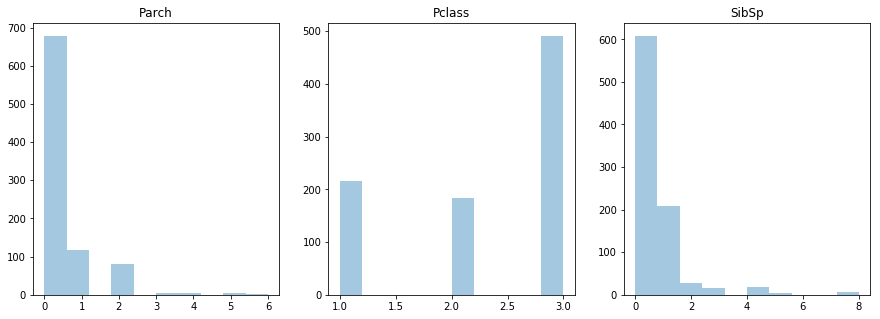

In [13]:
fig, axes=plt.subplots(1, len(num_cat_column_arr), figsize=(len(num_cat_column_arr)*5, 5))
for col_name, ax in zip(num_cat_column_arr, axes):
    ax.set_title(col_name)
    sns.distplot([x for x in x_train_df[col_name] if not math.isnan(x)], bins=10, kde=False, ax=ax)

### num_pure_column_arr

In [14]:
# discription of features
for x_df in x_data_dfs:
    display(x_df[num_pure_column_arr].describe())

,Age,Fare
count,714.000000,891.000000
mean,29.699118,32.204208
std,14.526497,49.693429
min,0.420000,0.000000
25%,20.125000,7.910400
50%,28.000000,14.454200
75%,38.000000,31.000000
max,80.000000,512.329200


,Age,Fare
count,332.000000,417.000000
mean,30.272590,35.627188
std,14.181209,55.907576
min,0.170000,0.000000
25%,21.000000,7.895800
50%,27.000000,14.454200
75%,39.000000,31.500000
max,76.000000,512.329200


In [15]:
# fill nan(standardize can not process nan value)
# 'Age' and 'Fare' need standardization
need_filna_column_arr = ['Age', 'Fare']
after_filna_column_arr = []
for col_name in need_filna_column_arr:
    after_col_name = 'filna_%s' % col_name
    after_filna_column_arr.append(after_col_name)
    for x_df in x_data_dfs:
        x_df[after_col_name] = x_df[col_name].fillna(x_df[col_name].mean())
        
display(x_df[after_filna_column_arr].shape, x_df[after_filna_column_arr].head())

(418, 2)

,filna_Age,filna_Fare
0,34.5,7.8292
1,47.0,7.0000
2,62.0,9.6875
3,27.0,8.6625
4,22.0,12.2875


Age
Fare
filna_Age
filna_Fare


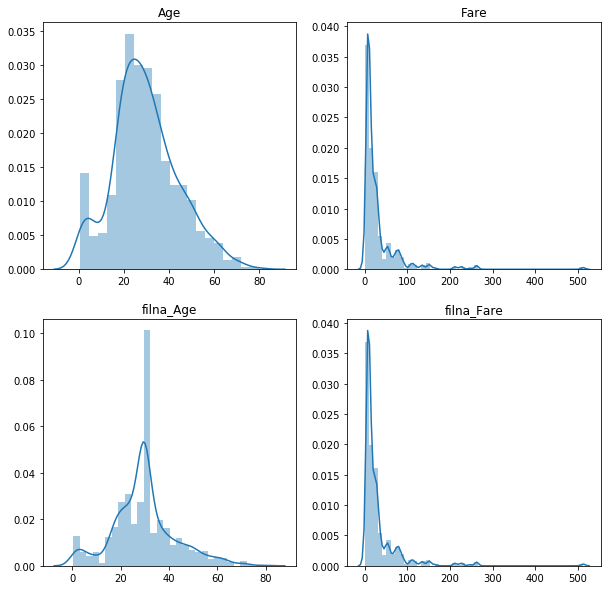

In [16]:
plot_cols = num_pure_column_arr + after_filna_column_arr
fig, axes=plt.subplots(int(len(plot_cols)/len(num_pure_column_arr)), len(num_pure_column_arr), figsize=(len(num_pure_column_arr)*5, int(len(plot_cols)/len(num_pure_column_arr))*5))
for col_name, ax in zip(plot_cols, axes.reshape(-1, 1)):
    print(col_name)
    ax[0].set_title(col_name)
    sns.distplot([x for x in x_train_df[col_name] if not math.isnan(x)], kde=True, ax=ax[0])
    
# As is shown in figure, 
# 'filna_Age' is not a good feature, it's shape is changed, 
# it's not good that Age' convert to 'filna_Age' by fill with mean.
# Maybe, matching is a better method.

In [17]:
need_minmax_column_arr = ['filna_Age']
after_minmax_column_arr = []
for col_name in need_minmax_column_arr:
    after_col_name = 'minmax_%s' % col_name
    after_minmax_column_arr.append(after_col_name)
    scaler = MinMaxScaler().fit(x_train_df[[col_name]].values)
    for x_df in x_data_dfs:
        x_df[after_col_name] = scaler.transform(x_df[[col_name]].values)
        
display(x_df[after_minmax_column_arr].shape, x_df[after_minmax_column_arr].head())

(418, 1)

,minmax_filna_Age
0,0.428248
1,0.585323
2,0.773813
3,0.334004
4,0.271174


filna_Age
minmax_filna_Age


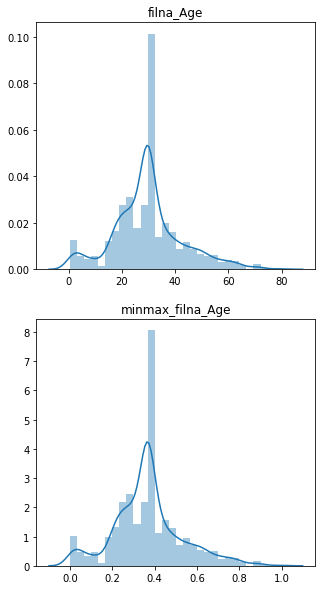

In [18]:
plot_cols = need_minmax_column_arr + after_minmax_column_arr
fig, axes=plt.subplots(int(len(plot_cols)/len(need_minmax_column_arr)), len(need_minmax_column_arr), figsize=(len(need_minmax_column_arr)*5, int(len(plot_cols)/len(need_minmax_column_arr))*5))
for col_name, ax in zip(plot_cols, axes.reshape(-1, 1)):
    print(col_name)
    ax[0].set_title(col_name)
    sns.distplot([x for x in x_train_df[col_name] if not math.isnan(x)], kde=True, ax=ax[0])

In [19]:
need_log_column_arr = ['filna_Fare']
after_log_column_arr = []
for col_name in need_log_column_arr:
    after_col_name = 'log_%s' % col_name
    after_log_column_arr.append(after_col_name)
    for x_df in x_data_dfs:
        x_df[after_col_name] = np.log1p(x_df[[col_name]].values)
#         x_df[after_col_name] = np.log(x_df[[col_name]].values + 1)
#         x_df[after_col_name] = np.log2(x_df[[col_name]].values + 1)
#         x_df[after_col_name] = np.log10(x_df[[col_name]].values + 1)
        
# display(x_df[after_log_column_arr].shape, x_df[after_log_column_arr].head())
display(x_df[need_log_column_arr + after_log_column_arr].shape, x_df[need_log_column_arr + after_log_column_arr].head())

(418, 2)

,filna_Fare,log_filna_Fare
0,7.8292,2.178064
1,7.0000,2.079442
2,9.6875,2.369075
3,8.6625,2.268252
4,12.2875,2.586824


filna_Fare
log_filna_Fare


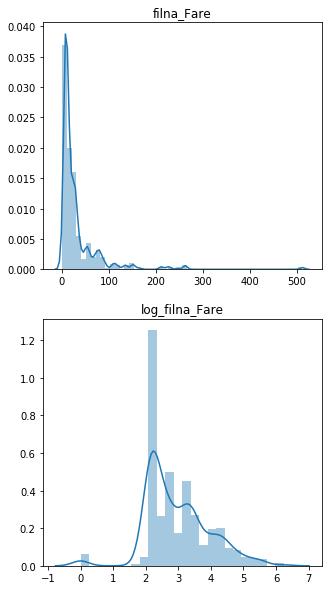

In [20]:
plot_cols = need_log_column_arr + after_log_column_arr
fig, axes=plt.subplots(int(len(plot_cols)/len(need_log_column_arr)), len(need_log_column_arr), figsize=(len(need_log_column_arr)*5, int(len(plot_cols)/len(need_log_column_arr))*5))
for col_name, ax in zip(plot_cols, axes.reshape(-1, 1)):
    print(col_name)
    ax[0].set_title(col_name)
    sns.distplot([x for x in x_train_df[col_name] if not math.isnan(x)], kde=True, ax=ax[0])
    
# As is shown in figure,
# log_filna_Fare is good, and it don't need another minmax convert.

## String columns
- token
- tf-idf
- word vector

https://www.zhihu.com/question/267606386/answer/390048040 词向量
